# Assignment One

In [2]:
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
from IPython.display import Image
import numpy as np

## Problem 1

### Functions 

In [35]:
def pull_community(link):
    '''
    This function pulls in the community boundary area for Chicago.

    link: API link

    returns: dictionary with community number as key, community name as value
    '''

    response = requests.get(link)
    d = response.json()

    comm_dict = []

    for comm in d:
        k = comm['area_num_1']
        l = comm['community']
        new = {'community_area': k, 'name': l}
        comm_dict.append(new)

    return pd.DataFrame(comm_dict)

    
def pull_data(api_link, inc = 50000):
    '''
    This function pulls data from the api_link and organizes it into a pandas dataframe.

    api_link: string containing api url
    inc: increment for data pull since api only returns (max) 50000 items at a time

    returns: dataframe
    '''

    off = 0

    full = []

    while True:
        url = f'{api_link}?$limit={inc}&$offset={off}'
        response = requests.get(url, timeout = 10)
        data = response.json()
        if data:
            full += data
            off += inc
        else: #empty response
            break

    return pd.DataFrame(full)

def avg_crime_nhood(*args):
    '''
    This function finds the mean number of crimes per community area.
    
    args: dataframes for each year 
    
    return: dataframe with community area and average crimes
    '''
    all_years = []
    
    for df in args:
        yr = df['year'].unique()[0]
        by_nhood = df.groupby(['community_area', 'primary_type']).count()[['id']]
        by_nhood = by_nhood.reset_index()
        col_name = f'{yr} Total'
        by_nhood.columns = ['community_area', 'Type', col_name]
        all_years.append(by_nhood)
        
#     if len(all_years) == 1:
#         final_counts = all_years[0]
#     elif len(all_years) == 2:
    final_counts = pd.merge(all_years[0], all_years[1], on = ['community_area','Type'], how='outer')
    final_counts = final_counts.fillna(0)
    col1 = final_counts.columns[2]
    col2 = final_counts.columns[3]
    final_counts['Average'] = round((final_counts[col2]+final_counts[col1])/2,1)
    final_counts['Percent Change'] = round((final_counts[col2]/final_counts[col1] -1)*100,1)
    final_counts['Type']=final_counts['Type'].str.capitalize()

        #final_counts = final_counts.sort_values('Percent Change', ascending=False)
#     else:
#         final_counts = pd.merge(all_years[0], all_years[1], on = 'community_area')
#         for i in range(2, len(all_years)):
#             final_counts = pd.merge(final_counts, all_years[i], on = 'community_area')
        
    return final_counts

def num_crimes_type(*args):
    '''
    This function calculates the total number of crimes committed across all 
    dataframes inputted.

    *args: dataframes containing crime records (each row is a crime)

    return: integer with number of crimes
    '''

    all_years = []

    for df in args:
        yr = df['year'].unique()[0]
        #print(yr)
        by_type = df.groupby('primary_type').count()[['id']]
        by_type = by_type.reset_index()
        col_name = f'{yr} Total'
        by_type.columns = ['Type', col_name]
        all_years.append(by_type)

#     if len(all_years) == 1:
#         final_counts = all_years[0]
#     elif len(all_years) == 2:
    final_counts = pd.merge(all_years[0], all_years[1], on = 'Type')
    col1 = final_counts.columns[1]
    col2 = final_counts.columns[2]
    final_counts['Percent Change'] = round((final_counts[col2]/final_counts[col1]-1)*100,1)
    final_counts['Type']=final_counts['Type'].str.capitalize()

#         #final_counts = final_counts.sort_values('Percent Change', ascending=False)
#     else:
#         final_counts = pd.merge(all_years[0], all_years[1], on = 'Type')
#         for i in range(2, len(all_years)):
#             final_counts = pd.merge(final_counts, all_years[i], on = 'Type')

    return final_counts


def mk_table(data, filename = 'table.png', dpi = 800, scale=False, fontsize = False):
    '''
    This function makes a matplotlib table from a pandas dataframe.

    data: pandas dataframe
    filename: filename to save table png
    dpi = resolution

    '''
    plt.figure(figsize=(8,6))
    plt.axis('off')

    cell_text = []
    for row in range(len(data)):
        cell_text.append(data.iloc[row])

    tab = plt.table(cellText=cell_text, 
        colLabels=data.columns, 
        loc='center')

    if fontsize:
        tab.auto_set_font_size(False)
        tab.set_fontsize(5)
    if scale:
        tab.scale(1.25,3)
        
    #plt.title(title)
    plt.savefig(filename, dpi = dpi, bbox_inces='tight')

def mk_bar(df, x_col, y_col, title, filename = 'bar.png', dpi = 500):
    '''
    This function makes a horizontal bar chart from a dataframe.

    df: dataframe
    x_col: name of column for the x-axis argument in the plot
    y_col: name of column for the y-axis argument in the plot
    filename: filename to save barchart png
    dpi = resolution

    return: None
    '''

    df = df.sort_values(y_col, ascending=True)
    df.plot.barh(x=x_col, y=y_col, legend = None)
    plt.title(title)
    plt.tick_params(axis='y', which='major', labelsize=6.5)
    plt.savefig(filename, bbox_inches='tight', dpi=400)
    
def most_common_yr(df, year = 2018):
    '''
    This function builds a dataframe that finds the most common crime type for each community area and aggregates to be used
    in a pie chart.
    
    df: dataframe from avg_crime_nhood
    
    returns: dataframe
    '''
    
    dict_n = []
    tgt_col = f'{year} Total'

    #make pie chart of the 3?
    for c in df['community_area'].unique():
        new = df[df['community_area']== c].sort_values(tgt_col, ascending=False)
        top = new.iloc[0]
        n = {'Type': top['Type'], tgt_col: top[tgt_col], 'area': top['community_area']}
        dict_n.append(n)
    
    return pd.DataFrame(dict_n)
    
    
def mk_pie(df, year, title, filename = 'pie.png'):
    '''
    This function makes a pie chart from a given dataframe.
    
    df: dataframe from most_common_yr
    
    returns: None
    '''
    
    df.set_index('Type', inplace=True, drop=True)
    final = df.groupby('Type').count()
    
    tgt_col = f'{year} Total'
    
    final.plot.pie(y=tgt_col, legend=None,
                   autopct='%1.0f%%',pctdistance=0.75, 
                   title = f'Most Common Type of Crime in {year}\n(by Community Area)')
    
    
def summary_nhood(df, area_num):
    '''
    This function creates a table summary of type of crime in 2017 and 2018 of a particular community area
    as well as a bar chart of the percent change.
    
    df: dataframe from avg_crime_nhood
    area_num: community_area number
    
    returns: None
    '''
    
    filtered = df[df['community_area'] == str(area_num)]
    filtered = filtered.set_index('community_area')
    
    f1 = f'nhood_{area_num}.png'
    mk_table(filtered, filename = f1)
    
    f2 = f'nhood_bar_{area_num}.png'
    title = f'Average Number of Crimes by Type (2017 to 2018)\nCommunity Area: {area_num}'
    mk_bar(filtered, 'Type', 'Average', title, f2)
    
    
    

In [5]:
# Links to use

#community_areas = 'https://data.cityofchicago.org/resource/igwz-8jzy.json'
crime_2017_api = 'https://data.cityofchicago.org/resource/d62x-nvdr.json'
crime_2018_api = 'https://data.cityofchicago.org/resource/3i3m-jwuy.json'

In [6]:
#nhood_dict = pull_community(community_areas)
df1 = pull_data(crime_2017_api)
df2 = pull_data(crime_2018_api)


In [7]:
#summary stats
x = num_crimes_type(df1, df2)

z=avg_crime_nhood(df1, df2)
a = most_common_yr(z)
b = most_common_yr(z, 2017)

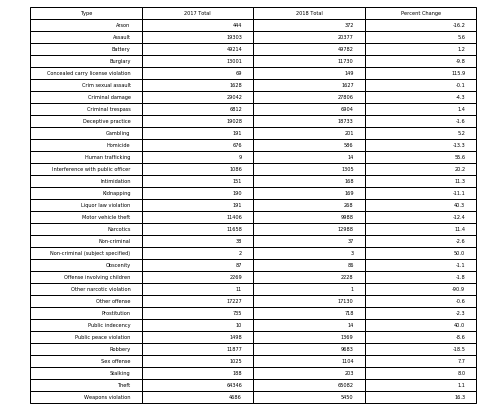

In [15]:
mk_table(x, 'test.png')

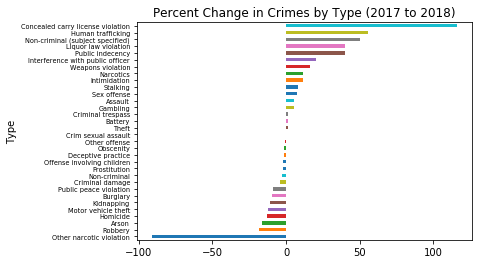

In [111]:
mk_bar(x, 'Type', 'Percent Change', 'Percent Change in Crimes by Type (2017 to 2018)', 'bar_type_chg.png')

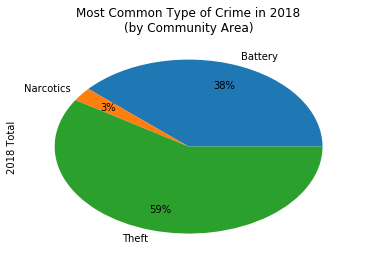

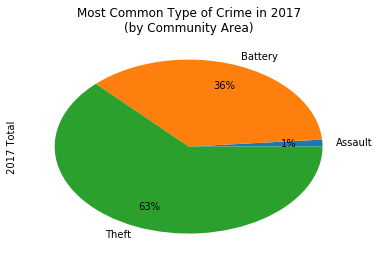

In [108]:
mk_pie(a, 2018, '2018 pie.png')
mk_pie(b, 2017, '2017 pie.png')

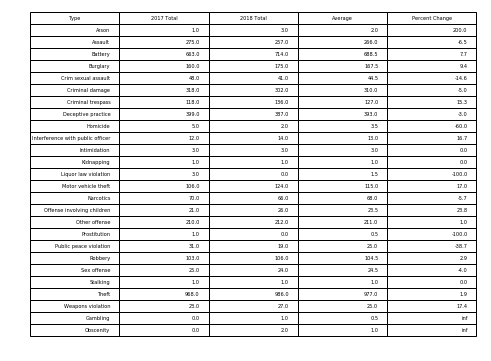

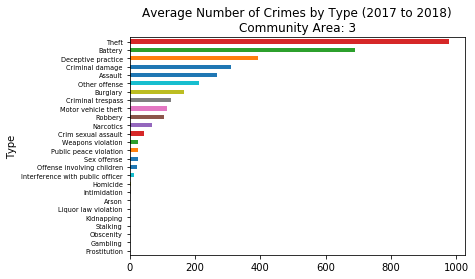

In [109]:
summary_nhood(z, '3')

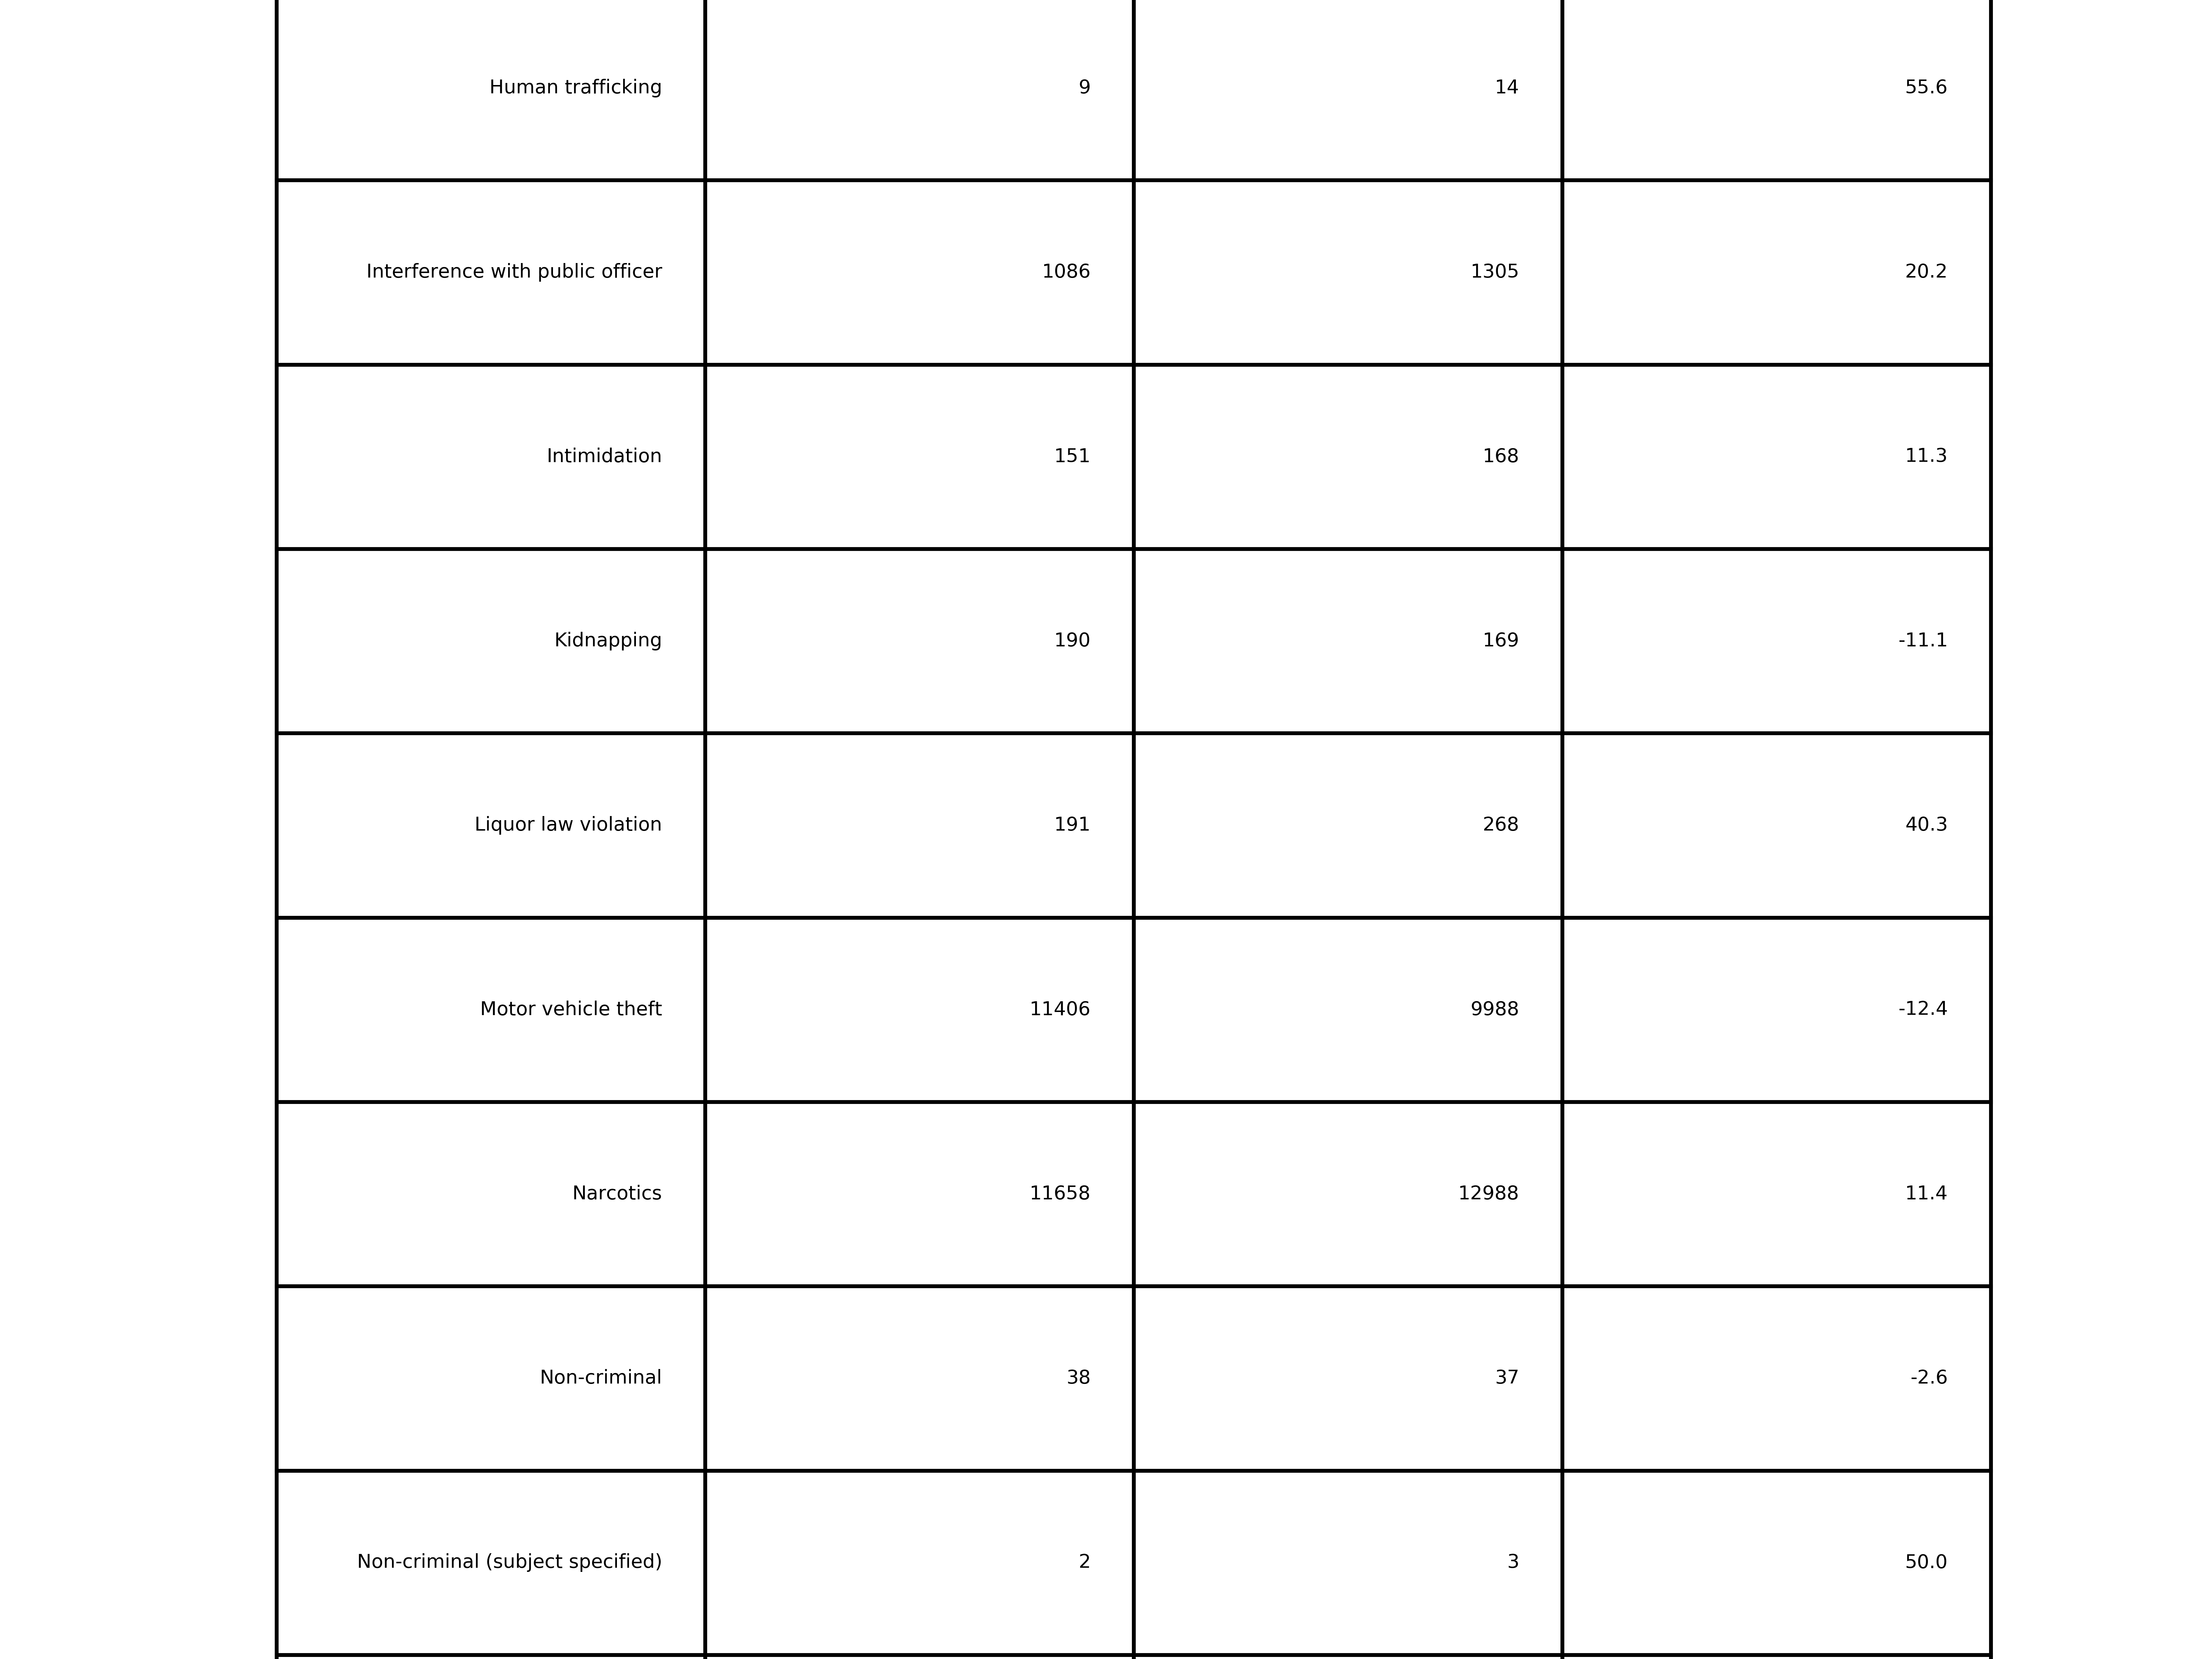

In [9]:
Image('table_by_type.png')

In [ ]:
Image('bar_type_chg.png')

In [ ]:
Image('2018 pie.png')

In [ ]:
Image('2017 pie

In [ ]:
Image('nhood_3.png')

In [ ]:
Image('nhood_bar_3.png')

In [ ]:
#experimental code
#z=avg_crime_nhood(df1, df2)
#z=pd.merge(nhood_dict, z, on = 'community_area')
# z2 = z[['community_area', '2017 Total', '2018 Total']]
# #z2.plot.scatter(x='2017 Total', y='2018 Total')
# #z1.sort_values('Percent Change', ascending=False)
# z3 = z1[z1['community_area']=='1'].sort_values('2018 Total', ascending=False)

dict_n = []

#make pie chart of the 3?
for c in z['community_area'].unique():
    new = z[z['community_area']== c].sort_values('2017 Total', ascending=False)
    top_2017 =new.iloc[0]
    n = dict(top_2017)
    dict_n.append(n)

a = pd.DataFrame(dict_n)
#a['type'].unique()
a.set_index('type', inplace=True, drop=True)
b = a.groupby('type').count()
b
#a.set_index('type', inplace=True, drop=True)
#a
#b.plot.pie(y='2018 Total', legend=None,autopct='%1.0f%%',pctdistance=0.75, title = 'Most Common Type of Crime in 2018')


#biggest pct increase: concealed carry license
#biggest pct decrease: other narcotics
vals = x.sort_values('Percent Change', ascending=False)
high = vals.iloc[0]
low = vals.iloc[-1]

hightype = high['Type'].upper()
lowtype = low['Type'].upper()
#z[z['type']==hightype]
z[z['type']== lowtype]

## Problem 2

### Functions

In [21]:
import geopandas
from shapely.geometry import Point
import censusgeocode as cg

In [40]:
def get_acs_blk_data(state, county, filename = 'census_data.csv'):
    '''
    This function retrieves block group data from the census_api and saves it to a csv.
    
    state: state code for api geographical hierarchy
    county: county code for api geographical hierarchy
    
    returns: dataframe with all block groups for the state and county
    '''

    all_tracts = f'https://api.census.gov/data/2016/acs/acs5?get=NAME&for=tract:*&in=state:{state}+county:{county}'
    
    response = requests.get(all_tracts)
    data = response.json()
    tracts_list = [x[-1] for x in data[1:]]

    full_census_data = 'empty'
    count=0
    for t in tracts_list:
        count +=1
        print(count)
        blkgrp = f'https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:{state}+county:{county}+tract:{t}&key=48b45a2062a735ab2c6960def7d8cd8223041485'
        print(blkgrp)
        response = requests.get(blkgrp)
        data = response.json()
        #print(data)

        df = pd.DataFrame(data)

        if type(full_census_data) == str:
            full_census_data = df
        else:
            full_census_data = pd.concat([full_census_data, df[1:]], ignore_index = True)

    full_census_data.to_csv(filename)
    return full_census_data

def find_tract_blk(lat, lng): 
    '''
    This function finds the census block info for a given latitude and longitude. Easy to use when only have one coordinate to check.
    
    lat: latitude
    lng: longitude
    
    return: FIPS census tract and block group code
    '''
    geo_info = cg.coordinates(x=lng,y=lat)
    block = geo_info['2010 Census Blocks'][0]['BLKGRP']

    tract = geo_info['2010 Census Blocks'][0]['TRACT']

    return tract+block



def ltlng_to_fips(df, geodf):
    '''
    This function uses spatial join to identify which the census blocks and tracts for data with latitude and longitude
    
    df: pandas dataframe with crime data
    geofile: geojson file with census block level data
    
    return: geodataframe 
    '''
    
    #add shapely Points to pandas dataframe
    df = df.dropna(subset=['latitude', 'longitude'])
    geometry = [Point(xy) for xy in zip(pd.to_numeric(df.longitude), pd.to_numeric(df.latitude))]
    df = df.drop(['longitude', 'latitude'], axis=1)
    crs = {'init': 'epsg:4326'}
    gdf = geopandas.GeoDataFrame(df, crs=crs, geometry=geometry)
    
    #join
    return geopandas.sjoin(gdf, geodf, how="inner", op='intersects')

def multiple_joins(types, df_list, geofile = 'block_bounds.geojson'):
    '''This function returns a dictionary of multiple spatial joins
    
    types: list of types to filter by
    df_list: list of dfs to do the join on
    
    returns: dictionary
    
    '''
    
    final = {}
    
    #read in geojson
    geodf =geopandas.read_file(geofile)
    
    for t in types:
        #print(t)
        for df in df_list:
            t = t.upper()
            yr = df['year'].unique()[0]
            #print(yr)
            tmp = df[df['primary_type'] == t]
            #print(tmp)
            
            joined = ltlng_to_fips(tmp, geodf)
            
            t = t.capitalize()
            key = f'{t} ({yr})'
            final[key] = joined
            
    return final

def build_summary_table(metrics, dict_df):
    '''
    This function builds a summary table of characteristics for each crime type in dict_df
    
    metrics: list of metrics for summary table
    dict_df: dictionary of df with census info for that crime (results of block_summary)
    
    returns: summary dataframe
    '''
    
    summary_table = pd.DataFrame()
    summary_table['Descriptive Metrics: Average'] = metrics
    
    for k, v in dict_df.items():
        print(k)
    
        blk_list = get_blk_list(v)
        blk_sum = block_summary(blk_list, census_df)
        
        values = get_metrics(blk_sum, metrics)
        
        summary_table[k] = values
        
    return summary_table

def get_metrics(df_block_info, metrics):
    '''
    Get summary metrics for summary table
    
    df_block_info: dataframe for crime type with block information
    metrics: columns to average
    
    return: list of values
    '''
    summary = []
    for m in metrics:
        val = round(df_block_info[m].mean(),2)
        if 'P' in m.upper():
            val = f'{val}%'
        summary.append(val)
        
    return summary

def get_blk_list(crime_df, q_thresh = 0.75):
    '''
    This function identifies the blocks that had a certain amount of crime (set by q_thresh)
    
    crime_df: df with specific type of crime (battery, homicide, etc) for one year
    q_thresh: quantile threshold to determine which blocks to look at
    
    return: list of block groups as strings
    '''
    
    crime_df['block'] = crime_df['tractce10'] + crime_df['blockce10'].str.slice(stop=1)
    by_block = crime_df.groupby('block').count()[['id']]
    q = by_block['id'].quantile(q_thresh)
    filtered = by_block[by_block['id'] > q]
    
    return list(filtered.index)
    
def block_summary(block_list, all_census):
    '''
    This function returns summary statistics for given blocks.
    
    block_list: list of blocks to summarize
    all_census: census dataframe
    
    return: dataframe with summary stats per block group
    '''
    summary = []
    
    for blk in block_list:
        tract = int(blk[0:-1])
        block = int(blk[-1])
        
        census_df = all_census[(all_census.tract == tract) & (all_census.block == block)]
        
        med_age = census_df['Median Age'].iloc[0]
        if med_age < 0:
            continue
        
        total_hh = census_df['Total Households'].iloc[0]
        hhinc_less_25 = round((sum([census_df['Households < 10k'].iloc[0], census_df['10k < Household < 15k'].iloc[0], census_df['15k < Household < 20k'].iloc[0], census_df['20k < Household < 25k'].iloc[0]])/total_hh)*100,2)
        hhinc_25_50 = round((sum([census_df['25k < Household < 30k'].iloc[0], census_df['30k < Household < 35k'].iloc[0], census_df['35k < Household < 40k'].iloc[0], census_df['40k < Household < 45k'].iloc[0], census_df['45k < Household < 50k'].iloc[0]])/total_hh)*100,2)
        hhinc_50_100 = round((sum([census_df['50k < Household < 60k'].iloc[0], census_df['60k < Household < 75k'].iloc[0], census_df['75k < Household < 100k'].iloc[0]])/total_hh)*100,2)
        #hhinc_over_100 = round((1 - hhinc_less_25 - hhinc_25_50 - hhinc_50_100)*100,2)
        
        total_race = census_df['Total Hispanic'].iloc[0] + census_df['Total Not Hispanic'].iloc[0]
        pct_hisp = round((census_df['Total Hispanic'].iloc[0]/total_race)*100, 2)
        pct_white = round((census_df['Total White'].iloc[0]/total_race)*100, 2)
        pct_black = round((census_df['Total Black'].iloc[0]/total_race)*100, 2)
        pct_asian = round((census_df['Total Asian'].iloc[0]/total_race)*100, 2)
        
        
        tmp = {'Block': blk, 'Median Age': med_age, 'Pct household income < 25k': hhinc_less_25, '25k < Pct household income < 50k': hhinc_25_50,
              '50k < Pct household income < 100k': hhinc_50_100, 'Percent Hispanic': pct_hisp,
              'Percent White': pct_white, 'Percent Black': pct_black, 'Percent Asian': pct_asian}
        
        summary.append(tmp)
    #print(summary)
    return pd.DataFrame(summary)    


#### Pull in ACS 5Y 2017 Data

Variable information:


'B01002_001E': 'Median age',

'B19001': HOUSEHOLD INCOME IN THE PAST 12 MONTHS,

'B19001_001E': 'Total', 

'B19001_002E': 'Less than 10,000',

'B19001_003E': '10000 to 14999',

'B19001_004E': '15000 to 19999',

'B19001_005E': '20000 to 24999',

'B19001_006E': '25000 to 29999',

'B19001_007E': '30000 to 34999',

'B19001_008E': '35000 to 39999',

'B19001_009E': '40000 to 45999',

'B19001_010E': '45000 to 49999',

'B19001_011E': '50000 to 59999',

'B19001_012E': '60000 to 74999',

'B19001_013E': '75000 to 99999',

'B03002_012E': 'Estimate!!Total!!Hispanic or Latino', 

'B03002_002E': 'Estimate!!Total!!Not Hispanic or Latino',

'B03002_003E': 'Estimate!!Total!!Not Hispanic or Latino!!White alone',

'B03002_004E': 'Estimate!!Total!!Not Hispanic or Latino!!Black or African American alone',

'B03002_006E': 'Estimate!!Total!!Not Hispanic or Latino!!Asian alone',

In [324]:
census_pull = get_acs_blk_data('17','031')

1
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:010100&key=48b45a2062a735ab2c6960def7d8cd8223041485
2
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:010201&key=48b45a2062a735ab2c6960def7d8cd8223041485
3
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_

23
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:020802&key=48b45a2062a735ab2c6960def7d8cd8223041485
24
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:020901&key=48b45a2062a735ab2c6960def7d8cd8223041485
25
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B030

45
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:031200&key=48b45a2062a735ab2c6960def7d8cd8223041485
46
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:031300&key=48b45a2062a735ab2c6960def7d8cd8223041485
47
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B030

67
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:050500&key=48b45a2062a735ab2c6960def7d8cd8223041485
68
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:050600&key=48b45a2062a735ab2c6960def7d8cd8223041485
69
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B030

89
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:061901&key=48b45a2062a735ab2c6960def7d8cd8223041485
90
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:061902&key=48b45a2062a735ab2c6960def7d8cd8223041485
91
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B030

111
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:070200&key=48b45a2062a735ab2c6960def7d8cd8223041485
112
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:070300&key=48b45a2062a735ab2c6960def7d8cd8223041485
113
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B

133
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:081201&key=48b45a2062a735ab2c6960def7d8cd8223041485
134
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:081202&key=48b45a2062a735ab2c6960def7d8cd8223041485
135
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B

155
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:110200&key=48b45a2062a735ab2c6960def7d8cd8223041485
156
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:110300&key=48b45a2062a735ab2c6960def7d8cd8223041485
157
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B

177
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:140800&key=48b45a2062a735ab2c6960def7d8cd8223041485
178
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:150200&key=48b45a2062a735ab2c6960def7d8cd8223041485
179
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B

199
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:160700&key=48b45a2062a735ab2c6960def7d8cd8223041485
200
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:160800&key=48b45a2062a735ab2c6960def7d8cd8223041485
201
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B

221
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:190401&key=48b45a2062a735ab2c6960def7d8cd8223041485
222
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:190402&key=48b45a2062a735ab2c6960def7d8cd8223041485
223
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B

243
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:210601&key=48b45a2062a735ab2c6960def7d8cd8223041485
244
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:210602&key=48b45a2062a735ab2c6960def7d8cd8223041485
245
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B

265
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:222500&key=48b45a2062a735ab2c6960def7d8cd8223041485
266
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:222600&key=48b45a2062a735ab2c6960def7d8cd8223041485
267
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B

287
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:240800&key=48b45a2062a735ab2c6960def7d8cd8223041485
288
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:240900&key=48b45a2062a735ab2c6960def7d8cd8223041485
289
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B

309
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:243300&key=48b45a2062a735ab2c6960def7d8cd8223041485
310
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:243400&key=48b45a2062a735ab2c6960def7d8cd8223041485
311
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B

331
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:252102&key=48b45a2062a735ab2c6960def7d8cd8223041485
332
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:252201&key=48b45a2062a735ab2c6960def7d8cd8223041485
333
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B

353
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:280900&key=48b45a2062a735ab2c6960def7d8cd8223041485
354
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:281900&key=48b45a2062a735ab2c6960def7d8cd8223041485
355
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B

375
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:301702&key=48b45a2062a735ab2c6960def7d8cd8223041485
376
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:301801&key=48b45a2062a735ab2c6960def7d8cd8223041485
377
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B

397
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:350400&key=48b45a2062a735ab2c6960def7d8cd8223041485
398
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:351000&key=48b45a2062a735ab2c6960def7d8cd8223041485
399
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B

419
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:390700&key=48b45a2062a735ab2c6960def7d8cd8223041485
420
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:400300&key=48b45a2062a735ab2c6960def7d8cd8223041485
421
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B

441
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:420800&key=48b45a2062a735ab2c6960def7d8cd8223041485
442
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:421200&key=48b45a2062a735ab2c6960def7d8cd8223041485
443
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B

463
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:440700&key=48b45a2062a735ab2c6960def7d8cd8223041485
464
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:440800&key=48b45a2062a735ab2c6960def7d8cd8223041485
465
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B

485
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:490600&key=48b45a2062a735ab2c6960def7d8cd8223041485
486
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:490700&key=48b45a2062a735ab2c6960def7d8cd8223041485
487
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B

507
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:530100&key=48b45a2062a735ab2c6960def7d8cd8223041485
508
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:530200&key=48b45a2062a735ab2c6960def7d8cd8223041485
509
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B

529
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:570200&key=48b45a2062a735ab2c6960def7d8cd8223041485
530
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:570300&key=48b45a2062a735ab2c6960def7d8cd8223041485
531
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B

551
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:610800&key=48b45a2062a735ab2c6960def7d8cd8223041485
552
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:611000&key=48b45a2062a735ab2c6960def7d8cd8223041485
553
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B

573
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:630800&key=48b45a2062a735ab2c6960def7d8cd8223041485
574
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:630900&key=48b45a2062a735ab2c6960def7d8cd8223041485
575
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B

595
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:660900&key=48b45a2062a735ab2c6960def7d8cd8223041485
596
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:661000&key=48b45a2062a735ab2c6960def7d8cd8223041485
597
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B

617
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:680600&key=48b45a2062a735ab2c6960def7d8cd8223041485
618
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:680900&key=48b45a2062a735ab2c6960def7d8cd8223041485
619
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B

639
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:700402&key=48b45a2062a735ab2c6960def7d8cd8223041485
640
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:700501&key=48b45a2062a735ab2c6960def7d8cd8223041485
641
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B

661
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:720500&key=48b45a2062a735ab2c6960def7d8cd8223041485
662
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:720600&key=48b45a2062a735ab2c6960def7d8cd8223041485
663
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B

683
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:760802&key=48b45a2062a735ab2c6960def7d8cd8223041485
684
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:760803&key=48b45a2062a735ab2c6960def7d8cd8223041485
685
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B

705
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:801000&key=48b45a2062a735ab2c6960def7d8cd8223041485
706
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:801100&key=48b45a2062a735ab2c6960def7d8cd8223041485
707
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B

727
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:802300&key=48b45a2062a735ab2c6960def7d8cd8223041485
728
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:802402&key=48b45a2062a735ab2c6960def7d8cd8223041485
729
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B

749
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:803012&key=48b45a2062a735ab2c6960def7d8cd8223041485
750
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:803013&key=48b45a2062a735ab2c6960def7d8cd8223041485
751
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B

771
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:803800&key=48b45a2062a735ab2c6960def7d8cd8223041485
772
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:803901&key=48b45a2062a735ab2c6960def7d8cd8223041485
773
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B

793
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:804505&key=48b45a2062a735ab2c6960def7d8cd8223041485
794
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:804506&key=48b45a2062a735ab2c6960def7d8cd8223041485
795
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B

815
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:804714&key=48b45a2062a735ab2c6960def7d8cd8223041485
816
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:804715&key=48b45a2062a735ab2c6960def7d8cd8223041485
817
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B

837
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:805112&key=48b45a2062a735ab2c6960def7d8cd8223041485
838
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:805201&key=48b45a2062a735ab2c6960def7d8cd8223041485
839
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B

859
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:806104&key=48b45a2062a735ab2c6960def7d8cd8223041485
860
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:806201&key=48b45a2062a735ab2c6960def7d8cd8223041485
861
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B

881
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:808001&key=48b45a2062a735ab2c6960def7d8cd8223041485
882
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:808002&key=48b45a2062a735ab2c6960def7d8cd8223041485
883
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B

903
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:810000&key=48b45a2062a735ab2c6960def7d8cd8223041485
904
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:810100&key=48b45a2062a735ab2c6960def7d8cd8223041485
905
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B

925
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:811701&key=48b45a2062a735ab2c6960def7d8cd8223041485
926
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:811702&key=48b45a2062a735ab2c6960def7d8cd8223041485
927
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B

947
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:813500&key=48b45a2062a735ab2c6960def7d8cd8223041485
948
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:813600&key=48b45a2062a735ab2c6960def7d8cd8223041485
949
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B

969
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:815500&key=48b45a2062a735ab2c6960def7d8cd8223041485
970
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:815600&key=48b45a2062a735ab2c6960def7d8cd8223041485
971
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B

991
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:817400&key=48b45a2062a735ab2c6960def7d8cd8223041485
992
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:817500&key=48b45a2062a735ab2c6960def7d8cd8223041485
993
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B

1013
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:819600&key=48b45a2062a735ab2c6960def7d8cd8223041485
1014
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:819700&key=48b45a2062a735ab2c6960def7d8cd8223041485
1015
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012

1035
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:820902&key=48b45a2062a735ab2c6960def7d8cd8223041485
1036
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:821001&key=48b45a2062a735ab2c6960def7d8cd8223041485
1037
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012

1057
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:822601&key=48b45a2062a735ab2c6960def7d8cd8223041485
1058
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:822602&key=48b45a2062a735ab2c6960def7d8cd8223041485
1059
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012

1079
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:823703&key=48b45a2062a735ab2c6960def7d8cd8223041485
1080
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:823704&key=48b45a2062a735ab2c6960def7d8cd8223041485
1081
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012

1101
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:824117&key=48b45a2062a735ab2c6960def7d8cd8223041485
1102
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:824119&key=48b45a2062a735ab2c6960def7d8cd8223041485
1103
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012

1123
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:825304&key=48b45a2062a735ab2c6960def7d8cd8223041485
1124
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:825400&key=48b45a2062a735ab2c6960def7d8cd8223041485
1125
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012

1145
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:826600&key=48b45a2062a735ab2c6960def7d8cd8223041485
1146
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:826700&key=48b45a2062a735ab2c6960def7d8cd8223041485
1147
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012

1167
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:828202&key=48b45a2062a735ab2c6960def7d8cd8223041485
1168
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:828300&key=48b45a2062a735ab2c6960def7d8cd8223041485
1169
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012

1189
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:829500&key=48b45a2062a735ab2c6960def7d8cd8223041485
1190
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:829600&key=48b45a2062a735ab2c6960def7d8cd8223041485
1191
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012

1211
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:830900&key=48b45a2062a735ab2c6960def7d8cd8223041485
1212
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:831000&key=48b45a2062a735ab2c6960def7d8cd8223041485
1213
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012

1233
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:833900&key=48b45a2062a735ab2c6960def7d8cd8223041485
1234
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:834000&key=48b45a2062a735ab2c6960def7d8cd8223041485
1235
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012

1255
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:836400&key=48b45a2062a735ab2c6960def7d8cd8223041485
1256
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:836500&key=48b45a2062a735ab2c6960def7d8cd8223041485
1257
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012

1277
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:839600&key=48b45a2062a735ab2c6960def7d8cd8223041485
1278
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:839700&key=48b45a2062a735ab2c6960def7d8cd8223041485
1279
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012

1299
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:842100&key=48b45a2062a735ab2c6960def7d8cd8223041485
1300
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:842200&key=48b45a2062a735ab2c6960def7d8cd8223041485
1301
https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,...,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E,state,county,tract,block group
1,"Block Group 2, Census Tract 101, Cook County, ...",31.3,939,262,41,131,145,37,0,66,...,8,122,2048,707,1292,13,17,031,010100,2
2,"Block Group 3, Census Tract 101, Cook County, ...",36.3,1025,117,37,44,46,32,91,46,...,85,190,1490,800,587,20,17,031,010100,3
3,"Block Group 1, Census Tract 101, Cook County, ...",47.5,284,62,69,0,0,29,0,0,...,24,98,496,219,180,0,17,031,010100,1
4,"Block Group 3, Census Tract 102.01, Cook Count...",40.7,412,32,0,11,0,38,0,0,...,48,310,628,418,156,0,17,031,010201,3
5,"Block Group 1, Census Tract 102.01, Cook Count...",38.9,659,71,48,44,64,69,47,13,...,72,193,1246,462,703,54,17,031,010201,1
6,"Block Group 2, Census Tract 102.01, Cook Count...",32.6,1599,302,70,111,113,72,101,90,...,139,1124,3696,1337,1916,67,17,031,010201,2
7,"Block Group 2, Census Tract 102.02, Cook Count...",31.3,516,41,10,48,35,47,19,62,...,47,312,907,432,446,18,17,031,010202,2
8,"Block Group 1, Census Tract 102.02, Cook Count...",56.3,460,79,32,61,45,39,17,19,...,50,405,863,386,280,167,17,031,010202,1
9,"Block Group 1, Census Tract 103, Cook County, ...",50.3,520,43,40,32,63,0,14,71,...,85,196,902,697,150,48,17,031,010300,1


In [18]:
census_df = pd.read_csv('census_data.csv',skiprows=1)
census_df = census_df.drop('0', axis=1)
census_df.columns = ['Name', 'Median Age', 'Total Households', 'Households < 10k', '10k < Household < 15k',
                    '15k < Household < 20k','20k < Household < 25k','25k < Household < 30k',
                    '30k < Household < 35k','35k < Household < 40k','40k < Household < 45k',
                    '45k < Household < 50k', '50k < Household < 60k','60k < Household < 75k',
                    '75k < Household < 100k', 'Total Hispanic', 'Total Not Hispanic', 'Total White',
                    'Total Black', 'Total Asian', 'state', 'county', 'tract', 'block']


In [58]:
#census api work/variables
#f = 'https://api.census.gov/data/2013/acs1?get=NAME,B02015_009E,B02015_009M&for=tract:*&in=state:51+county:51177'
#for all tracts cook county 
#all tracts
f='https://api.census.gov/data/2016/acs/acs5?get=NAME,B01002_001E,B01002_001M,B01002_002E,B01002_002M,B01002_003E,B01002_003M&for=tract:*&in=state:17+county:031'
#get block groups for each tract, will need to loop
g = 'https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B01002_001M,B01002_002E,B01002_002M,B01002_003E,B01002_003M&for=block+group:*&in=state:17+county:031+tract:140702'
h= 'https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:010100'
j='https://api.census.gov/data/2017/acs/acs5?get=NAME,B01002_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B03002_012E,B03002_002E,B03002_003E,B03002_004E,B03002_006E&for=block+group:*&in=state:17+county:031+tract:010202&key=48b45a2062a735ab2c6960def7d8cd8223041485'
r = requests.get(j)
r.json()
#f='https://api.census.gov/data/2016/acs/acs5?get=NAME,B01002_001E,B01002_001M,B01002_002E,B01002_002M,B01002_003E,B01002_003M&for=tract:*&in=state:01&key=4b034d76dca86dd92bf767cae1ec01e592b13e10'

# avs_var = {'B19001_001E': 'HOUSEHOLD INCOME IN THE PAST 12 MONTHS, ESTIMATE', 
#            'B03002_012E': 'Estimate!!Total!!Hispanic or Latino', 
#            'B03002_002E': 'Estimate!!Total!!Not Hispanic or Latino',
#           'B03002_003E': 'Estimate!!Total!!Not Hispanic or Latino!!White alone',
#            'B03002_004E': 'Estimate!!Total!!Not Hispanic or Latino!!Black or African American alone',
#           'B03002_006E': 'Estimate!!Total!!Not Hispanic or Latino!!Asian alone',
#           'B01002_001E': 'Median age'}


#j='https://api.census.gov/data/2010/dec/sf1?get=NAME,&'

[['NAME',
  'B01002_001E',
  'B19001_001E',
  'B19001_002E',
  'B19001_003E',
  'B19001_004E',
  'B19001_005E',
  'B19001_006E',
  'B19001_007E',
  'B19001_008E',
  'B19001_009E',
  'B19001_010E',
  'B19001_011E',
  'B19001_012E',
  'B19001_013E',
  'B03002_012E',
  'B03002_002E',
  'B03002_003E',
  'B03002_004E',
  'B03002_006E',
  'state',
  'county',
  'tract',
  'block group'],
 ['Block Group 2, Census Tract 102.02, Cook County, Illinois',
  '31.3',
  '516',
  '41',
  '10',
  '48',
  '35',
  '47',
  '19',
  '62',
  '40',
  '45',
  '25',
  '22',
  '47',
  '312',
  '907',
  '432',
  '446',
  '18',
  '17',
  '031',
  '010202',
  '2'],
 ['Block Group 1, Census Tract 102.02, Cook County, Illinois',
  '56.3',
  '460',
  '79',
  '32',
  '61',
  '45',
  '39',
  '17',
  '19',
  '16',
  '13',
  '35',
  '17',
  '50',
  '405',
  '863',
  '386',
  '280',
  '167',
  '17',
  '031',
  '010202',
  '1']]

#### Spatial Join to match census tract/blocks

In [28]:
joined1 = multiple_joins(['BATTERY', 'HOMICIDE'], [df1, df2])

joined2= multiple_joins(['DECEPTIVE PRACTICE','SEX OFFENSE'], [df1, df2])

metrics = ['Median Age', 'Pct household income < 25k', '25k < Pct household income < 50k',
              '50k < Pct household income < 100k', 'Percent Hispanic',
              'Percent White', 'Percent Black', 'Percent Asian']

In [38]:
tbl1 = build_summary_table(metrics, joined1)
tbl2 = build_summary_table(metrics, joined2)

Battery (2017)
Battery (2018)
Homicide (2017)
Homicide (2018)
Deceptive practice (2017)
Deceptive practice (2018)
Sex offense (2017)
Sex offense (2018)


/anaconda3/envs/geopdenv/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in long_scalars
/anaconda3/envs/geopdenv/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in long_scalars
/anaconda3/envs/geopdenv/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in long_scalars


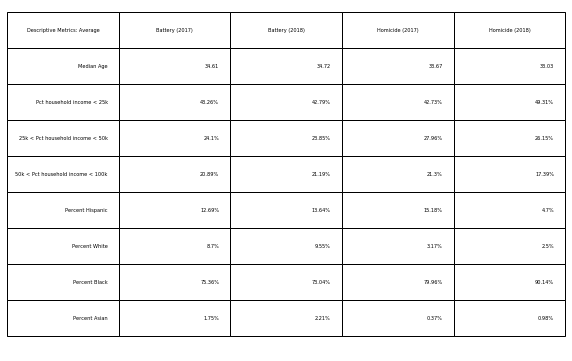

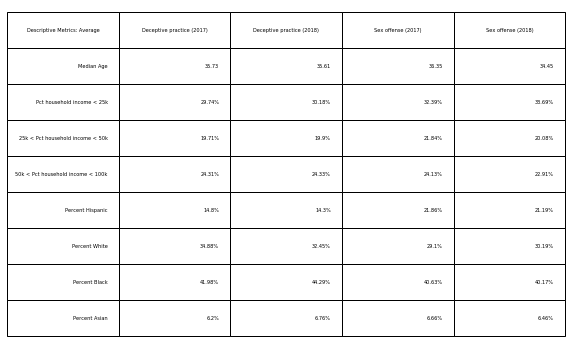

In [39]:
mk_table(tbl1, 'problem2_summary1.png', scale=True, fontsize=True)
mk_table(tbl2, 'problem2_summary2.png', scale=True, fontsize=True)

In [37]:
def build_summary_table(metrics, dict_df):
    '''
    This function builds a summary table of characteristics for each crime type in dict_df
    
    metrics: list of metrics for summary table
    dict_df: dictionary of df with census info for that crime (results of block_summary)
    
    returns: summary dataframe
    '''
    
    summary_table = pd.DataFrame()
    summary_table['Descriptive Metrics: Average'] = metrics
    
    for k, v in dict_df.items():
        print(k)
    
        blk_list = get_blk_list(v)
        blk_sum = block_summary(blk_list, census_df)
        
        values = get_metrics(blk_sum, metrics)
        
        summary_table[k] = values
        
    return summary_table

def get_metrics(df_block_info, metrics):
    summary = []
    for m in metrics:
        val = round(df_block_info[m].mean(),2)
        if 'P' in m.upper():
            val = f'{val}%'
        summary.append(val)
        
    return summary

def get_blk_list(crime_df, q_thresh = 0.75):
    '''
    This function identifies the blocks that had a certain amount of crime (set by q_thresh)
    
    crime_df: df with specific type of crime (battery, homicide, etc) for one year
    q_thresh: quantile threshold to determine which blocks to look at
    
    return: list of block groups as strings
    '''
    
    crime_df['block'] = crime_df['tractce10'] + crime_df['blockce10'].str.slice(stop=1)
    by_block = crime_df.groupby('block').count()[['id']]
    q = by_block['id'].quantile(q_thresh)
    filtered = by_block[by_block['id'] > q]
    
    return list(filtered.index)
    

In [26]:
def block_summary(block_list, all_census):
    '''
    This function returns summary statistics for given blocks.
    
    block_list: list of blocks to summarize
    all_census: census dataframe
    
    return: dataframe with summary stats per block group
    '''
    summary = []
    
    for blk in block_list:
        tract = int(blk[0:-1])
        block = int(blk[-1])
        
        census_df = all_census[(all_census.tract == tract) & (all_census.block == block)]
        
        med_age = census_df['Median Age'].iloc[0]
        if med_age < 0:
            continue
        
        total_hh = census_df['Total Households'].iloc[0]
        hhinc_less_25 = round((sum([census_df['Households < 10k'].iloc[0], census_df['10k < Household < 15k'].iloc[0], census_df['15k < Household < 20k'].iloc[0], census_df['20k < Household < 25k'].iloc[0]])/total_hh)*100,2)
        hhinc_25_50 = round((sum([census_df['25k < Household < 30k'].iloc[0], census_df['30k < Household < 35k'].iloc[0], census_df['35k < Household < 40k'].iloc[0], census_df['40k < Household < 45k'].iloc[0], census_df['45k < Household < 50k'].iloc[0]])/total_hh)*100,2)
        hhinc_50_100 = round((sum([census_df['50k < Household < 60k'].iloc[0], census_df['60k < Household < 75k'].iloc[0], census_df['75k < Household < 100k'].iloc[0]])/total_hh)*100,2)
        #hhinc_over_100 = round((1 - hhinc_less_25 - hhinc_25_50 - hhinc_50_100)*100,2)
        
        total_race = census_df['Total Hispanic'].iloc[0] + census_df['Total Not Hispanic'].iloc[0]
        pct_hisp = round((census_df['Total Hispanic'].iloc[0]/total_race)*100, 2)
        pct_white = round((census_df['Total White'].iloc[0]/total_race)*100, 2)
        pct_black = round((census_df['Total Black'].iloc[0]/total_race)*100, 2)
        pct_asian = round((census_df['Total Asian'].iloc[0]/total_race)*100, 2)
        
        
        tmp = {'Block': blk, 'Median Age': med_age, 'Pct household income < 25k': hhinc_less_25, '25k < Pct household income < 50k': hhinc_25_50,
              '50k < Pct household income < 100k': hhinc_50_100, 'Percent Hispanic': pct_hisp,
              'Percent White': pct_white, 'Percent Black': pct_black, 'Percent Asian': pct_asian}
        
        summary.append(tmp)
    #print(summary)
    return pd.DataFrame(summary)

In [ ]:
census_df.columns = ['Name', 'Median Age', 'Total Households', 'Households < 10k', '10k < Household < 15k',
                    '15k < Household < 20k','20k < Household < 25k','25k < Household < 30k',
                    '30k < Household < 35k','35k < Household < 40k','40k < Household < 45k',
                    '45k < Household < 50k', '50k < Household < 60k','60k < Household < 75k',
                    '75k < Household < 100k', 'Total Hispanic', 'Total Not Hispanic', 'Total White',
                    'Total Black', 'Total Asian', 'state', 'county', 'tract', 'block']

In [147]:
round(1.52,1)

1.5

In [ ]:
'B01002_001E': 'Median age',

'B19001': HOUSEHOLD INCOME IN THE PAST 12 MONTHS,

'B19001_001E': 'Total', 

'B19001_002E': 'Less than 10,000',

'B19001_003E': '10000 to 14999',

'B19001_004E': '15000 to 19999',

'B19001_005E': '20000 to 24999',

'B19001_006E': '25000 to 29999',

'B19001_007E': '30000 to 34999',

'B19001_008E': '35000 to 39999',

'B19001_009E': '40000 to 45999',

'B19001_010E': '45000 to 49999',

'B19001_011E': '50000 to 59999',

'B19001_012E': '60000 to 74999',

'B19001_013E': '75000 to 99999',

'B03002_012E': 'Estimate!!Total!!Hispanic or Latino', 

'B03002_002E': 'Estimate!!Total!!Not Hispanic or Latino',

'B03002_003E': 'Estimate!!Total!!Not Hispanic or Latino!!White alone',

'B03002_004E': 'Estimate!!Total!!Not Hispanic or Latino!!Black or African American alone',

'B03002_006E': 'Estimate!!Total!!Not Hispanic or Latino!!Asian alone',